In [1]:
#Iporting nessary libraries 
import h2o
import pandas as pd
import numpy as np

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,9 mins 07 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_Aditya_Jain_lwamvf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,235.7 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [3]:
# set random seed for reproducibility
np.random.seed(345)

In [4]:
# Set the number of rows and begin populating the dataframe
N = 1000
df = pd.DataFrame({'id': range(N)})

In [5]:
# create an unrelated variable pets
names = np.array(['Anil', 'Amit', 'Jisvik', 'Jitendra', 'pinki', 'Ishi', 'Aani', 'Shalu','Nandani', 'Gautham', 'Manish'])

In [6]:
# assign names randomly by id
df = df.assign(name = names[df.id.values % len(names)])

In [7]:
# create an age column in our dataframe
df = df.assign(age = np.random.uniform(18, 71, N).round())

In [8]:
# create a column for years of education, and ensure it doesn't go below zero
v = np.random.normal(15, 3, N).round()
v = np.where(v < 0, 0, v)
df = df.assign(education = v)

In [9]:
# create a column for performance review score, on a scale of 1 to 9
v = np.random.normal(5, 2, N).round()
v = np.where(v < 1, 1, v)
v = np.where(v > 9, 9, v)
df = df.assign(performance_review = v)

In [10]:
# create a column for salary based on age
# adjust for performance review and education and add some noise
# add some interaction between education and performance review
v = 20000 + (df.age.values * 3)**2
v += df.education * 1000
v += df.performance_review * 250
v += df.education * df.performance_review * 500
v += np.random.normal(5000, 5000, N)
df = df.assign(income = v.round(-2))

In [28]:
df.describe(include='all')

,id,name,age,education,performance_review,income
count,1000.000000,1000,1000.000000,1000.000000,1000.000000,1000.000000
unique,NaN,11,NaN,NaN,NaN,NaN
top,NaN,pinki,NaN,NaN,NaN,NaN
freq,NaN,91,NaN,NaN,NaN,NaN
mean,499.500000,NaN,44.478000,14.870000,5.074000,98584.400000
std,288.819436,NaN,15.179985,3.040451,1.958663,23312.759197
min,0.000000,NaN,18.000000,5.000000,1.000000,43900.000000
25%,249.750000,NaN,31.000000,13.000000,4.000000,81600.000000
50%,499.500000,NaN,44.000000,15.000000,5.000000,97250.000000
75%,749.250000,NaN,58.000000,17.000000,6.000000,114400.000000


In [11]:
# create an H2O frame named people
people = h2o.H2OFrame(
    df,
    destination_frame='people'
)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
# split data into train, validation, and test sets
train, valid, test = people.split_frame(
    ratios=[0.8, 0.1],
    destination_frames=['people_train', 'people_valid', 'people_test'],
    seed=123
)

In [13]:
# how many rows in train/valid/test (slighly off with small data sets)
print("%d/%d/%d" % (train.nrows, valid.nrows, test.nrows))

788/118/94


In [14]:
# set up our x and y
y = 'income'
# don't include y or our id column in the features
ignore_fields = [y, 'id']
x = [i for i in train.names if i not in ignore_fields]

In [15]:
# now train a GBM on this data
from h2o.estimators.gbm import H2OGradientBoostingEstimator
m1 = H2OGradientBoostingEstimator(model_id='defaults')
m1.train(x, y, train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
m1.mae(train=True)

2997.792284660533

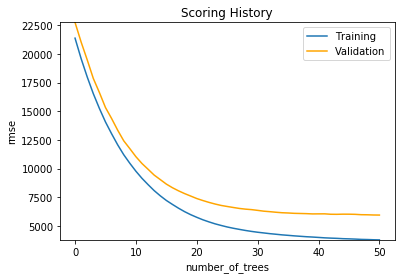

In [21]:
m1.plot()

In [17]:
m1.mae(valid=True)

4870.243174245147

In [18]:
perf = m1.model_performance(test)
perf.mae()

4276.8354606392095

In [19]:
# now what happens if we deliberately overfit the model
m2 = H2OGradientBoostingEstimator(model_id='overfit', 
                                  ntrees=1000, 
                                  max_depth=10
                                 )
m2.train(x, y, train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [20]:
# compare MAE across train, valid, and test
print("Train: %d --> %d" % (m1.mae(train=True), m2.mae(train=True)))
print("Valid: %d --> %d" % (m1.mae(valid=True), m2.mae(valid=True)))
print(" Test: %d --> %d" % (perf.mae(), m2.model_performance(test).mae()))

Train: 2997 --> 239
Valid: 4870 --> 5581
 Test: 4276 --> 4982


In [40]:
# We have overfit the model with model 2, reducing the training error significantly from model 1, 
# but increasing both the validation and test error.